In [2]:
import argparse
import time
import os
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import joblib

import warnings
warnings.filterwarnings('ignore')

In [5]:
def load_dataset() -> pd.DataFrame:
    path = '../dataset.csv'
    df = pd.read_csv(path, parse_dates=['Datetime'])
    print("*"*15 +  " DATASET INFO: " + "*"*15 + f"\n {df.info()}")
    print("*"*15 +  " DATASET HEAD: " + "*"*15 + f"\n {df.head()}")
    print("*"*15 +  " NUMBER OF ROWS: " + "*"*15 + f"\n {len(df)}")

    return df

In [6]:
df = load_dataset()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   Datetime           1709 non-null   datetime64[ns, UTC]
 1   Close              1709 non-null   float64            
 2   SMA7               1709 non-null   float64            
 3   SMA20              1709 non-null   float64            
 4   SMA50              1709 non-null   float64            
 5   SMA200             1709 non-null   float64            
 6   EMA21              1709 non-null   float64            
 7   EMA50              1709 non-null   float64            
 8   EMA200             1709 non-null   float64            
 9   RSI14              1709 non-null   float64            
 10  RSI30              1709 non-null   float64            
 11  MACD               1709 non-null   float64            
 12  MACD_Hist          1709 non-null   float64      

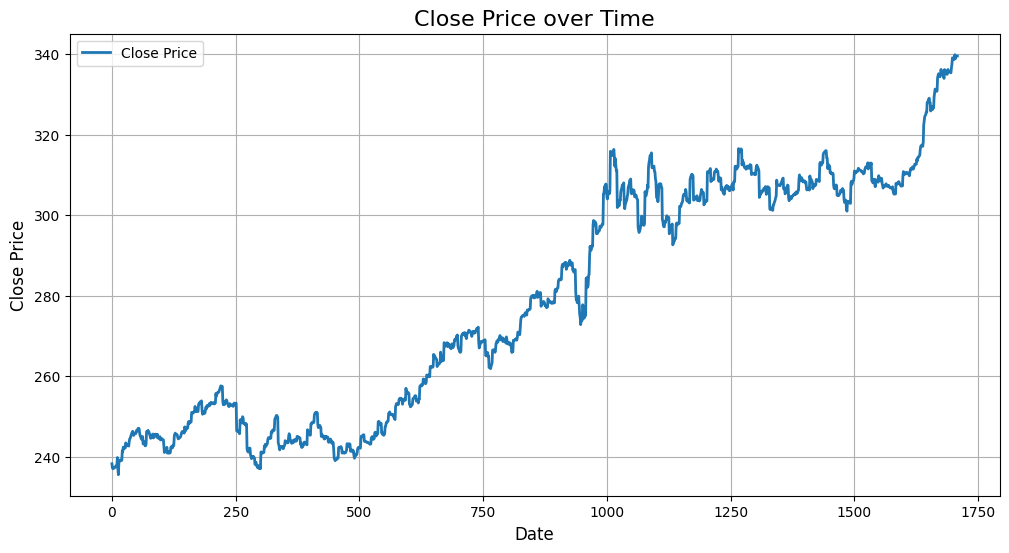

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Close Price", linewidth=2)
plt.title("Close Price over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def scale_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    features = [col for col in df.columns if col not in ['Datetime', 'Close']]
    target = 'Close'

    df[features] = feature_scaler.fit_transform(df[features])
    df[target] = target_scaler.fit_transform(df[[target]])

    df.to_csv('../scaled_dataset.csv', index=False)

    print("*"*15 +  " DATASET HEAD: " + "*"*15 + f"\n {df.head()}")

    joblib.dump(feature_scaler, 'scalers/feature_scaler.pkl')
    joblib.dump(target_scaler, 'scalers/target_scaler.pkl')

    return df

In [9]:
df_scaled = scale_dataset(df)

*************** DATASET HEAD: ***************
                    Datetime     Close      SMA7  SMA20     SMA50   SMA200  \
0 2024-09-17 13:30:00+00:00  0.026059  0.001216    0.0  0.005111  0.02373   
1 2024-09-17 14:30:00+00:00  0.016383  0.001216    0.0  0.005111  0.02373   
2 2024-09-17 15:30:00+00:00  0.014179  0.001216    0.0  0.005111  0.02373   
3 2024-09-17 16:30:00+00:00  0.014658  0.001216    0.0  0.005111  0.02373   
4 2024-09-17 17:30:00+00:00  0.018011  0.001216    0.0  0.005111  0.02373   

      EMA21     EMA50    EMA200     RSI14  ...  Vol_Ratio       OBV  \
0  0.009027  0.009172  0.010454  0.308031  ...   0.160677  0.063837   
1  0.003766  0.003867  0.004436  0.308031  ...   0.160677  0.060330   
2  0.001181  0.001278  0.001512  0.308031  ...   0.160677  0.056946   
3  0.000037  0.000121  0.000201  0.308031  ...   0.160677  0.060319   
4  0.000190  0.000207  0.000261  0.308031  ...   0.160677  0.062891   

   Price_Change  Price_Momentum_5  Price_Momentum_20  Trend_Str

In [11]:
class ProfessionalLSTM(nn.Module):
    def __init__(self, input_size=20, hidden_size=128, num_layers=3, dropout=0.3):
        super(ProfessionalLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=8, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size // 2, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out_transposed = lstm_out.transpose(0, 1)  
        attn_out, _ = self.attention(lstm_out_transposed, lstm_out_transposed, lstm_out_transposed)
        attn_out = attn_out.transpose(0, 1) 
        lstm_out = self.layer_norm(lstm_out + attn_out)
        context = torch.mean(lstm_out, dim=1)
 
        out = self.relu(self.fc1(context))
        out = self.dropout1(out)
        # residual = out
        
        out = self.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        
        return out

In [12]:
def create_professional_lstm(input_size=20, hidden_size=128, num_layers=3, dropout=0.3):
    return ProfessionalLSTM(input_size, hidden_size, num_layers, dropout)

**CODE BY GPT**

Sequences shape: X=(1679, 30, 38), y=(1679,)
Epoch 1/150, Loss: 0.024422
Epoch 10/150, Loss: 0.003128
Epoch 20/150, Loss: 0.001438
Epoch 30/150, Loss: 0.000930
Epoch 40/150, Loss: 0.000760
Epoch 50/150, Loss: 0.000659
Epoch 60/150, Loss: 0.000583
Epoch 70/150, Loss: 0.000500
Epoch 80/150, Loss: 0.000495
Epoch 90/150, Loss: 0.000421
Epoch 100/150, Loss: 0.000416
Epoch 110/150, Loss: 0.000478
Epoch 120/150, Loss: 0.000484
Epoch 130/150, Loss: 0.000496
Epoch 140/150, Loss: 0.000398
Epoch 150/150, Loss: 0.000384
Model saved as professional_lstm.pth
R2 Score: -0.6115
MSE: 168.4773
RMSE: 12.9799
MAE: 9.7169
MAPE: 3.01%


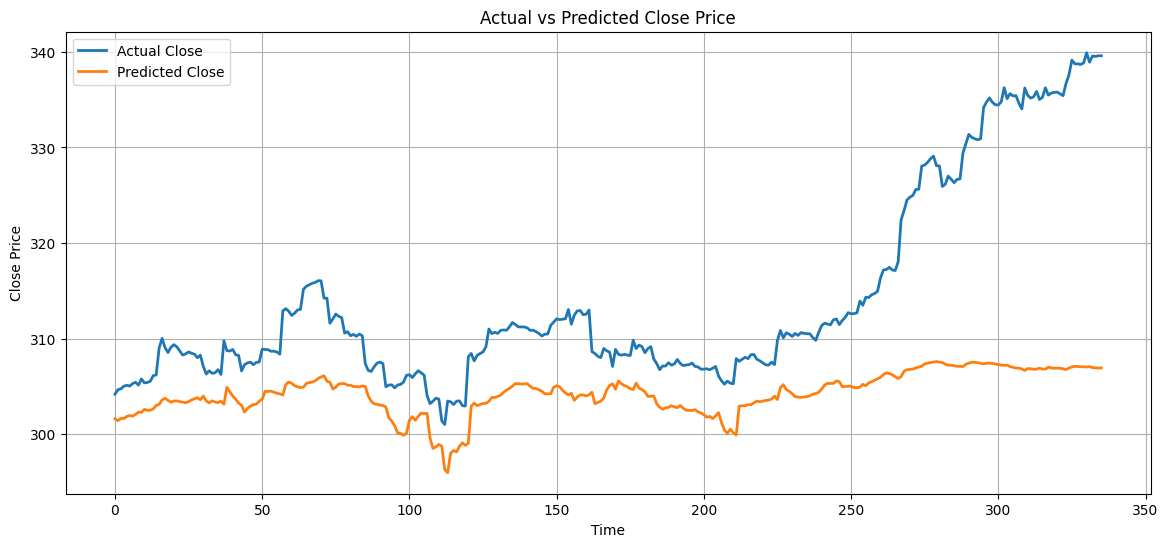

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# 1. Helper: Create sequences (lag features included)
# -------------------------
def create_sequences(data, target_column='Close', seq_length=30):
    """
    Convert dataframe into sequences for LSTM training.
    Includes all numeric features including past 'Close' values.
    
    data: pd.DataFrame (numeric, scaled)
    target_column: str, name of target column
    seq_length: int, number of past timesteps to include
    """
    X, y = [], []
    data_values = data.values
    target_idx = data.columns.get_loc(target_column)
    
    for i in range(len(data) - seq_length):
        X.append(data_values[i:i+seq_length])        # sequence of past timesteps
        y.append(data_values[i+seq_length, target_idx])  # target at next timestep
    
    return np.array(X), np.array(y)

# -------------------------
# 2. Load your dataset
# -------------------------
df = df_scaled.copy()
# Keep only numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df_numeric = df[numeric_cols]

SEQ_LENGTH = 30
X, y = create_sequences(df_numeric, target_column='Close', seq_length=SEQ_LENGTH)
print(f"Sequences shape: X={X.shape}, y={y.shape}")

# -------------------------
# 3. Train-test split (80/20)
# -------------------------
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# -------------------------
# 4. Dataloaders
# -------------------------
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# 5. Model
# -------------------------
model = create_professional_lstm(input_size=X.shape[2], hidden_size=128, num_layers=3, dropout=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# 6. Training loop
# -------------------------
EPOCHS = 150
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS}, Loss: {epoch_loss:.6f}")

# -------------------------
# 7. Save model
# -------------------------
torch.save(model.state_dict(), 'professional_lstm.pth')
print("Model saved as professional_lstm.pth")

# -------------------------
# 8. Predictions
# -------------------------
model.eval()
y_pred = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = model(xb)
        y_pred.append(pred.cpu().numpy())
y_pred = np.concatenate(y_pred, axis=0)

# -------------------------
# 9. Inverse transform using scaler
# -------------------------
target_scaler = joblib.load('scalers/target_scaler.pkl')
y_test_inv = target_scaler.inverse_transform(y_test.numpy())
y_pred_inv = target_scaler.inverse_transform(y_pred)

# -------------------------
# 10. Metrics
# -------------------------
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv)/y_test_inv)) * 100

print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# -------------------------
# 11. Plot results
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Close', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Close', linewidth=2)
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
